In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from numpy import cos, sin
from scipy.spatial.distance import cdist

In [2]:
def generate_points(n,L,sigma): #generates n points in the L by L square
    return np.array(np.split(sigma + (L-2*sigma)*np.random.rand(2*n),n))

In [3]:
def direct_sampling(n,L,sigma): #direct sampling: repeatedly samples n points until they form a correct configuration
    test = False
    while not(test):
        X = generate_points(n,L,sigma)
        dist = cdist(X,X)
        dist[dist==0] += np.max(dist)
        if np.min(dist) > 2*sigma:
            test = True
    return(X)

In [4]:
direct_sampling(16,10,0.1)

array([[ 7.36422221,  7.90487099],
       [ 3.74061387,  6.64429757],
       [ 5.55459977,  9.23713184],
       [ 2.39834101,  0.49836127],
       [ 1.32553274,  3.58681007],
       [ 9.27371347,  7.69574497],
       [ 3.98553711,  3.62821123],
       [ 7.77559653,  0.88135051],
       [ 0.76853683,  3.6669157 ],
       [ 5.15720703,  1.60486306],
       [ 5.46263516,  1.81526161],
       [ 9.88316242,  1.54900751],
       [ 6.92718687,  2.49361272],
       [ 7.68807625,  3.04538377],
       [ 9.12614687,  4.59854984],
       [ 1.28349611,  1.04849053]])

In [5]:
def plot(X,L): #makes plot of points (represented by dots)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_ylim([0, L])
    ax.set_xlim([0, L])
    plt.scatter(X[:,0],X[:,1])
    plt.show()

In [6]:
def plot2(X,L,sigma): #makes plot of points (represented by filled circles)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_ylim([0, L])
    ax.set_xlim([0, L])
    for i, (x,y) in enumerate(X):
        ax.add_artist(plt.Circle((x,y), sigma))
    plt.scatter(X[:,0],X[:,1])
    plt.show()

In [7]:
n = 16
L = 4
sigma = 0.2
X = direct_sampling(n,L,sigma)

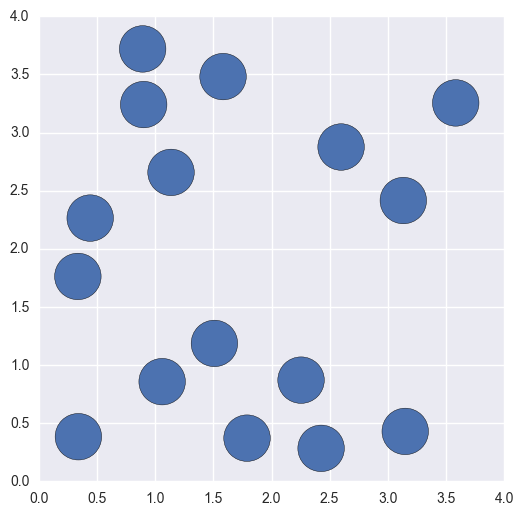

In [8]:
# plot(X,L) #unnecessary
plot2(X,L,sigma)

In [9]:
def periodic_initial_condition(n,L): #regular periodic initial configuration
    m = int(np.sqrt(n))
    l = np.linspace(0,(m-1)/(m)*L,m)+L/(2*m)
    return np.array([(a,b) for a in l for b in l])

In [10]:
n = 4**2
L = 4
sigma = 0.2
X = periodic_initial_condition(n,L)

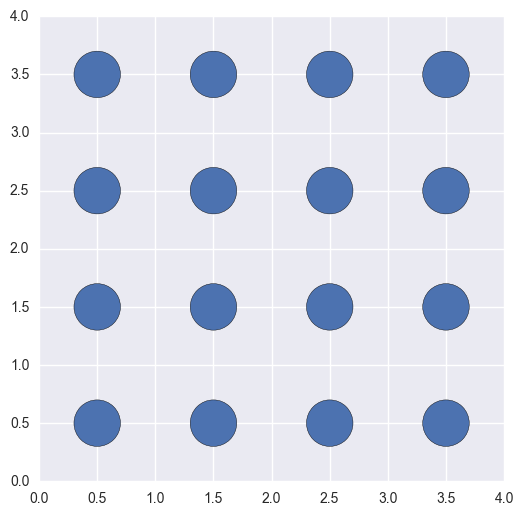

In [11]:
plot2(X,L,sigma)

In [12]:
def rotate(X,theta):
    
    #this functions takes the positions of the disks, and given the direction of the proposed move (theta)
    #rotates the positions of the disks so that the direction of the proposed move is horizontal in the new coordinate
    #system
    
    O = np.array([[cos(-theta),-sin(-theta)],[sin(-theta),cos(-theta)]]) # orthogonal matrix of rotation
    
    return(np.dot(X,O.T))

See effect of rotate function with the next two plots

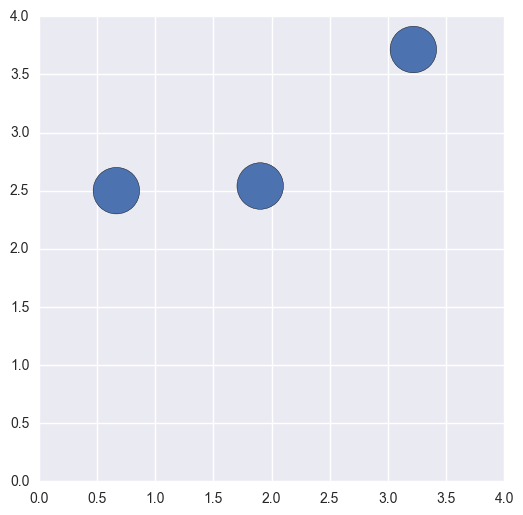

In [13]:
X = direct_sampling(3,4,0.2) # sample three points
plot2(X,4,0.2)

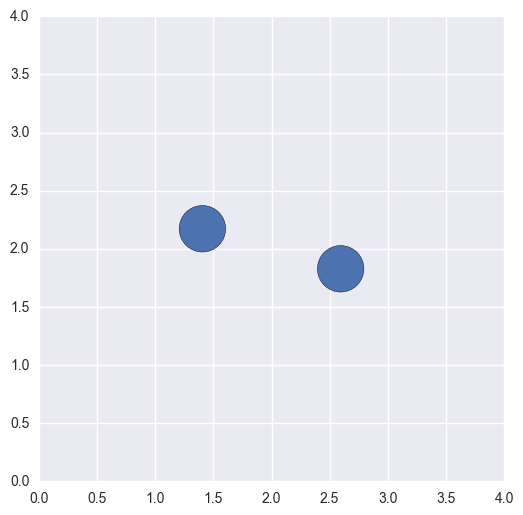

In [14]:
X1 = rotate(X,np.pi/10) # rotate points by angle
plot2(X1,4,0.2)

In [15]:
def MCMC_step(X,L,sigma,stepsize):
    #this function represents an iteration of the MCMC algorithm
    
    #1- Pick a point
    I = np.random.randint(len(X))
    
    #2- Propose a move: direction and distance
    theta,step = (2*np.pi,stepsize) * np.random.rand(2)
    
    #3- Check if proposed move is still inside the box: reject if not
    X_new = np.copy(X)
    X_new[I] += (step*cos(theta),step*sin(theta)) #X_new is the new configuration, that we will return if it passes all tests
    if not(sigma < X_new[I,0] < L-sigma):
        return(X,False)
    if not(sigma < X_new[I,1] < L-sigma):
        return(X,False)
    
    #4- Rotate points
    X1 = rotate(X,theta)
    X_other = np.delete(X1,I,axis=0) #set of points other than the one that was picked

    #5- Check if there is a collision: reject if yes
    X_near = X_other[ np.squeeze(cdist(X_other,[X1[I]])) < step + 2*sigma ]
    if len(X_near)==0: # if all other points points are too far from the one that was picked, there will be no collision: accept
        return(X_new,True)
    
    X2 = X_near[ (X1[I,0] < X_near[:,0])*(X_near[:,0] < X1[I,0] + step) ]
    if (np.sum(np.abs(X2[:,1] - X1[I,1]) < 2*sigma) > 0):
        return(X,False)
    
    if (np.min( np.squeeze( cdist(X_near,[X1[I]+(step,0)]) ) ) < 2*sigma):
        return(X,False)
    
    #6- If the proposed move passed all tests: accept and return new positions
    return(X_new,True)

In [16]:
n = 4**2
L = 4
sigma = 0.2
X = periodic_initial_condition(n,L)

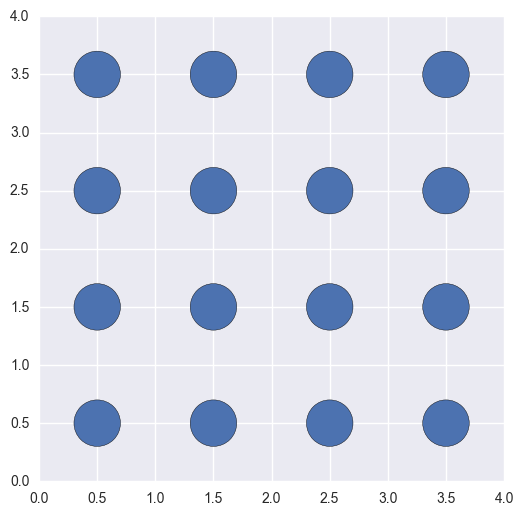

In [17]:
plot2(X,L,sigma)

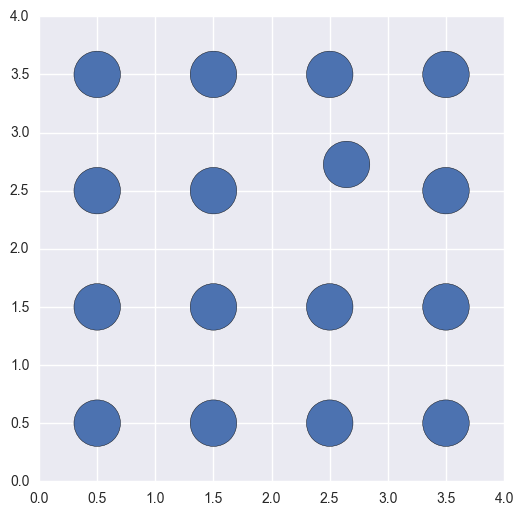

In [18]:
X1,A = MCMC_step(X,L,sigma,3*sigma)
if A: #plot new distribution if the move was accepted
    plot2(X1,L,sigma)

In [19]:
X1 = np.copy(X)
iterations = 10000
delta = 5*sigma
S = 0
for t in range(iterations):
    X1,A = MCMC_step(X1,L,sigma,delta)
    S += A

Acceptance rate = 0.5221


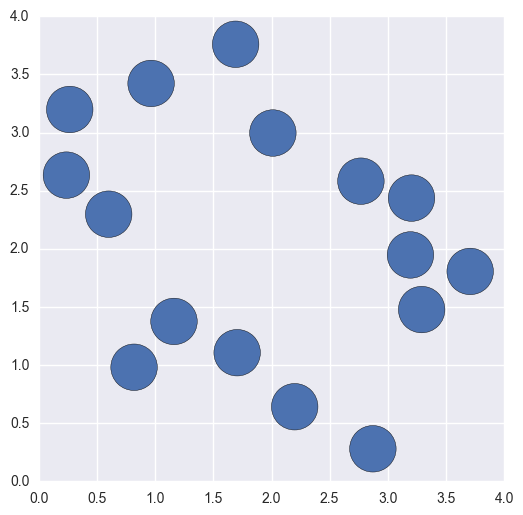

In [20]:
print('Acceptance rate = '+str(S/iterations))
plot2(X1,L,sigma)

In [21]:
def number_of_points(density,L,sigma):
    #computes the needed number of points to achieve a given density, for given size of box and radius of spheres
    number = (density/np.pi)*(L/sigma)**2
    return ((int(np.sqrt(number)))**2)

In [42]:
density = 0.5
L = 20
sigma = 0.75
n = number_of_points(density,L,sigma)
X = periodic_initial_condition(n,L)

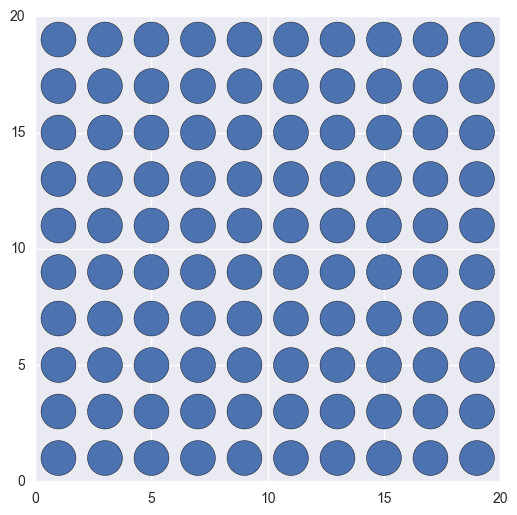

In [43]:
plot2(X,L,sigma)

In [44]:
X1 = np.copy(X)
iterations = 100000
delta = 0.2
S = 0
for t in range(iterations):
    X1,A = MCMC_step(X1,L,sigma,delta*sigma)
    S += A

Acceptance rate = 0.858


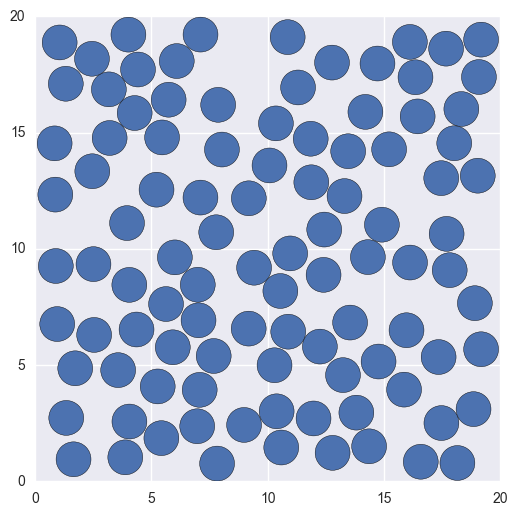

In [45]:
print('Acceptance rate = '+str(S/iterations))
plot2(X1,L,sigma)